In [1]:
import pandas as pd

firewall = pd.read_csv('firewall.csv')

# simplifying dataframe column names
firewall.columns = [
    'source', 
    'destination', 
    'nat_source', 
    'nat_destination', 
    'action', 
    'b_total', 
    'b_sent', 
    'b_received', 
    'packets', 
    'time', 
    'p_sent', 
    'p_received'
]

firewall.head()

,source,destination,nat_source,nat_destination,action,b_total,b_sent,b_received,packets,time,p_sent,p_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [2]:
firewall['action'].unique()

array(['allow', 'drop', 'deny', 'reset-both'], dtype=object)

In [3]:
# simplifying actions to allowed or not allowed
firewall['allowed'] = firewall['action'].apply(lambda tag: 1 if tag == 'allow' else 0)
firewall = firewall.drop('action', axis=1)
firewall.head()

,source,destination,nat_source,nat_destination,b_total,b_sent,b_received,packets,time,p_sent,p_received,allowed
0,57222,53,54587,53,177,94,83,2,30,1,1,1
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,1
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,1
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,1
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,1


In [4]:
firewall.describe()

,source,destination,nat_source,nat_destination,b_total,b_sent,b_received,packets,time,p_sent,p_received,allowed
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505,0.574376
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271,0.494441
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000,1.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000,1.000000


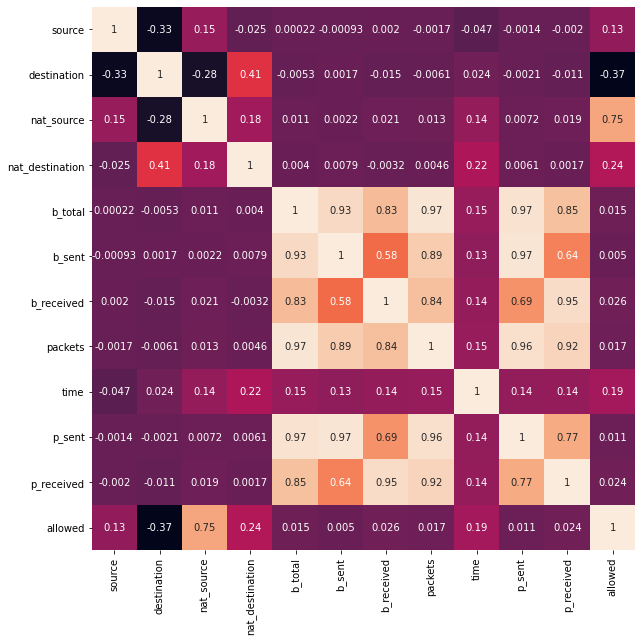

In [5]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

corr_matrix = np.corrcoef(firewall.T)

plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix, 
    cbar=False, 
    annot=True, 
    square=True, 
    xticklabels=firewall.columns, 
    yticklabels=firewall.columns)

In [6]:
from sklearn.model_selection import train_test_split

label    = 'allowed'
features = ['nat_source', 'nat_destination', 'time']

X = firewall[features]
y = firewall[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

In [7]:
from sklearn.preprocessing import MinMaxScaler

# needed to reduce complexity
# https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
scaler         = MinMaxScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [8]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression().fit(X_train_scaled, y_train)
logistic.score(X_train_scaled, y_train), logistic.score(X_test_scaled, y_test)

(0.9711489552178071, 0.9730818531404505)

In [9]:
validation_test_set = (firewall
    .drop_duplicates(subset='allowed', keep="first")
    .copy()
    .reset_index(drop=True))

validation_test_x = validation_test_set.loc[:, features]
validation_test_y = validation_test_set.loc[:, label]

validation_test_x_scaled = scaler.transform(validation_test_x)

logistic.predict(validation_test_x_scaled) == [1, 0]

array([ True,  True])